# Mass Transports

Transport diagnostics for flow through major straits.

## Theory

Formally, mass transports are given by
$$T_x = \rho u  $$
$$T_y = \rho v  $$

Mass transports are diagnostics that are calculated online by the model:

|variable|long name|units|dimensions|
|-|
|tx_trans|T-cell i-mass transport|Sv|(time,st_ocean,xu_ocean,yt_ocean)|
|ty_trans|T-cell j-mass transport|Sv|(time,st_ocean,xt_ocean,yu_ocean)|


These variables are saved in `ocean.nc` files.

## Calculation

In [1]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
# import seaborn as sns

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/home/157/amh157/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
from joblib import Memory
memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/', verbose=0)

In [4]:
cc.start_cluster(diagnostics_port=8787)

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 8787:127.0.0.1:8787 vdi-n6.nci.org.au -l amh157


Client Scheduler: tcp://127.0.0.1:35790 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [5]:
# Strait locations: [minlon, maxlon, minlat, maxlat]
# Add as many as you like, but they must be zonal or meridional
straits = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('Drake Passage', [-69.9, -69.9, -71.6, -51.0]),
            ('Lombok Strait', [-244.6, -243.6, -8.6, -8.6]),
            ('Ombai Strait',  [-235.0+360, -235.0+360, -9.2, -8.1]),
            ('Timor Strait',  [-235.9+360, -235.9+360, -11.9, -9.9]),
            ('Bering Strait', [-172, -167, 65.8, 65.8]),
            ('Denmark Strait',[-42, -22, 65.8, 65.8])
            ])

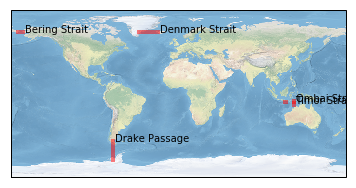

In [16]:
# TODO: plot straits on actual model bathymetry 


import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

for strait, (xmin, xmax, ymin, ymax) in straits.items():

    plt.plot([xmin, xmax], [ymin, ymax],
            color='red', linewidth=4, alpha=0.5,
             transform=ccrs.Geodetic() )
   
    plt.annotate(xy=(xmin, ymin), xycoords='data',
                 xytext=(xmax+2, ymax),
                 s=strait,
               #  arrowprops=dict(facecolor='black', shrink=0.05),
                 transform=ccrs.Geodetic(),
                clip_on=True)

#ax.set_global()
#plt.annotate(xy=(0, 0), s='origin', transform=ccrs.Geodetic())
#plt.show()


In [6]:
##@memory.cache
def calc_transport(ekey, strait):
    """
    Calculate barotropic transport across a given 
     line of latitude or longitude.
     
    Designed for flow through straits.
    """
    
    expt = exptdata.exptdict[ekey]['expt']
    n = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    print('Calculating {} {} transport'.format(expt, strait))
    print('with {} files, time units of {} and offset of  {} days'.format(n, time_units, offset))
    
    xmin, xmax, ymin, ymax = straits[strait]
    
    if xmin == xmax:                
        #tx_trans = cc.get_nc_variable(expt, 
        #                        'ocean.nc', 
        #                        'tx_trans',
        #                         chunks={'st_ocean':None},
        #                         n=n,
        #                         time_units='days since 1958-01-01')
        tx_trans = cc.get_nc_variable(expt, 
                                'ocean_month.nc', 
                                'tx_trans_int_z',
                                 n=n,
                                 time_units=time_units, offset=offset)
        
        transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('yt_ocean')#.sum('st_ocean')

    elif ymin == ymax:
        #ty_trans = cc.get_nc_variable(expt, 
        #                              'ocean.nc', 
        #                              'ty_trans',
        #                              chunks={'st_ocean':None},
        #                              n=n,
        #                              time_units='days since 1958-01-01')
        ty_trans = cc.get_nc_variable(expt, 
                                      'ocean_month.nc', 
                                      'ty_trans_int_z',
                                      n=n,
                                      time_units=time_units, offset=offset)
        transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
                            .sel(xt_ocean=slice(xmin, xmax))\
                            .sum('xt_ocean')#.sum('st_ocean')
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    
    transport = transport.compute()
       
    return transport

Calculating 1deg_jra55v13_iaf_spinup1_A Drake Passage transport
with None files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Calculating 1deg_jra55v13_iaf_spinup1_A Lombok Strait transport
with None files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Calculating 1deg_jra55v13_iaf_spinup1_A Ombai Strait transport
with None files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Calculating 1deg_jra55v13_iaf_spinup1_A Timor Strait transport
with None files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Calculating 1deg_jra55v13_iaf_spinup1_A Bering Strait transport
with None files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Calculating 1deg_jra55v13_iaf_spinup1_A Denmark Strait transport
with None files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Calculating 025deg_jra55v13_iaf Drake Passage transport
with None files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 025deg_jra55v13_iaf Lombok Strait transport
with None files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 025deg_jra55v13_iaf Ombai Strait transport
with None files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 025deg_jra55v13_iaf Timor Strait transport
with None files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 025deg_jra55v13_iaf Bering Strait transport
with None files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 025deg_jra55v13_iaf Denmark Strait transport
with None files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 01deg_jra55v13_iaf Drake Passage transport
with None files, time units of None and offset of  None days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 01deg_jra55v13_iaf Lombok Strait transport
with None files, time units of None and offset of  None days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 01deg_jra55v13_iaf Ombai Strait transport
with None files, time units of None and offset of  None days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 01deg_jra55v13_iaf Timor Strait transport
with None files, time units of None and offset of  None days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 01deg_jra55v13_iaf Bering Strait transport
with None files, time units of None and offset of  None days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 01deg_jra55v13_iaf Denmark Strait transport
with None files, time units of None and offset of  None days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


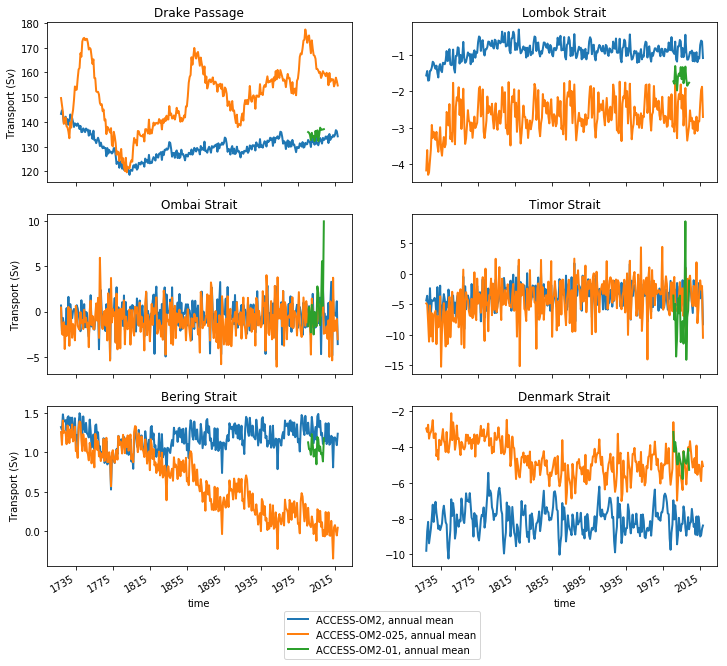

In [8]:
ncols = 2
nrows = math.ceil(len(straits)/ncols)
tstart = 1e10
tend = -1e10
# transports = copy.deepcopy(exptdata.exptdict)  # this will store speed fields under the same keys as exptdata.exptdict
plt.figure(figsize=(12,10))
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    desc = exptdata.exptdict[ekey]['desc']
    for i, strait in enumerate(straits):
# convert from kg/s to Sv, assuming typical in-situ density of 1036kg/m^3
# https://www.nature.com/scitable/knowledge/library/key-physical-variables-in-the-ocean-temperature-102805293
#        if ekey == '01deg':
#            transport = calc_transport(expt, strait,n=410)/1e6/1036
#             tstart = min(tstart, transport['time'].data[0])  # first time in model data
#             tend = max(tend, transport['time'].data[-1])  # final time in model data
#        else:
        transport = calc_transport(ekey, strait)/1e6/1036
        transport_mean = transport.resample(time='A').mean('time')
        plt.subplot(nrows, ncols, i+1)
        transport_mean.plot(label=desc+', annual mean', linewidth=2)
        #transport.plot(label=desc, linewidth=0.2, alpha=0.5)
        plt.title(strait)
        plt.ylabel('')
        plt.gca().autoscale()

for k in range(1,i+2,2):
    plt.subplot(nrows, ncols, k)
    plt.ylabel('Transport (Sv)')

for k in range(1,i,1):
    plt.subplot(nrows, ncols, k)
    plt.xlabel('')
    plt.gca().axes.xaxis.set_ticklabels([])

# for k in range(1,i+2,1):
#     plt.subplot(nrows, ncols, k)
#     plt.gca().xlim([tstart, tend])

plt.subplot(nrows, ncols, i+1)
plt.legend(bbox_to_anchor=(-0.1,-0.25), loc='upper center')

savefigure('strait_transports')

### A plot for Indonesian Seas only

Calculating 1deg_jra55v13_iaf_spinup1_A Lombok Strait transport
with -12 files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Calculating 1deg_jra55v13_iaf_spinup1_A Ombai Strait transport
with -12 files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Calculating 1deg_jra55v13_iaf_spinup1_A Timor Strait transport
with -12 files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Calculating 025deg_jra55v13_iaf Lombok Strait transport
with -30 files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 025deg_jra55v13_iaf Ombai Strait transport
with -30 files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 025deg_jra55v13_iaf Timor Strait transport
with -30 files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 01deg_jra55v13_iaf Lombok Strait transport
with None files, time units of None and offset of  None days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 01deg_jra55v13_iaf Ombai Strait transport
with None files, time units of None and offset of  None days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Calculating 01deg_jra55v13_iaf Timor Strait transport
with None files, time units of None and offset of  None days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


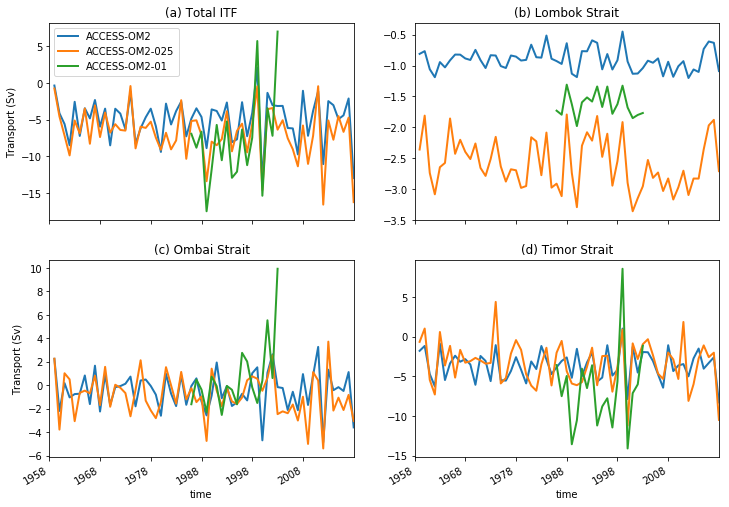

In [8]:
itf_straits = ['Lombok Strait', 'Ombai Strait',  'Timor Strait']
plt.figure(figsize=(12,8))
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    desc = exptdata.exptdict[ekey]['desc']
    for i, strait in enumerate(itf_straits):
# convert from kg/s to Sv, assuming typical in-situ density of 1036kg/m^3
# https://www.nature.com/scitable/knowledge/library/key-physical-variables-in-the-ocean-temperature-102805293
        #if ekey == '01deg':
        #    transport = calc_transport(expt, strait,n=410)/1e6/1036
        #else:
        transport = calc_transport(ekey, strait)/1e6/1036
        transport_mean = transport.resample(time='A').mean('time')
        
        if i==0:
            total_transport = transport_mean
        else:
            total_transport = total_transport + transport_mean
            
        plt.subplot(2, 2, i+2)
        transport_mean.plot(label=desc, linewidth=2)
        #transport.plot(label=desc, linewidth=0.2, alpha=0.5)
        plt.ylabel('')
        plt.gca().autoscale()
        
    plt.subplot(221)
    total_transport.plot(label=desc, linewidth=2)
    plt.title('(a) Total ITF')
    plt.ylabel('')
    plt.gca().autoscale()
    
    

for k in range(1,i+2,2):
    plt.subplot(2, 2, k)
    plt.ylabel('Transport (Sv)')

for k in range(1,3,1):
    plt.subplot(2, 2, k)
    plt.xlabel('')
    plt.gca().axes.xaxis.set_ticklabels([])

plt.subplot(221)
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.legend()

plt.subplot(222)
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('(b) '+itf_straits[0])

plt.subplot(223)
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('(c) '+itf_straits[1])

plt.subplot(224)
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('(d) '+itf_straits[2])

savefigure('ITF_transport')

Calculating 1deg_jra55v13_iaf_spinup1_A Drake Passage transport
with -12 files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Calculating 025deg_jra55v13_iaf Drake Passage transport
with -30 files, time units of days since 1718-01-01 and offset of  -87658 days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Calculating 01deg_jra55v13_iaf Drake Passage transport
with None files, time units of None and offset of  None days
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


CPU times: user 1min 13s, sys: 36 s, total: 1min 49s
Wall time: 2min 20s


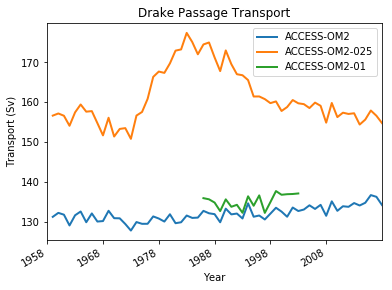

In [9]:
%%time
strait = 'Drake Passage'
for ekey in exptdata.exptdict.keys():
    transport = calc_transport(ekey, strait)/1e6/1036
    transport_mean = transport.resample(time='A').mean('time')
    transport_mean.plot(label=exptdata.exptdict[ekey]['desc'], linewidth=2)

plt.legend()
plt.gca().autoscale()
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('Drake Passage Transport')
plt.xlabel('Year')
plt.ylabel('Transport (Sv)')
savefigure('DP_transport')